# In-Class Assignment Machine Learning in Finance

## Objective

In this Jupyter Notebook, we aim to model and calibrate call option prices derived from a Variance Gamma (VG) model using simulation
data and observed market data. We focus on three machine learning techniques: KNN, a feedforward Neural Network, and
Gaussian Process Regression. The goal is to first establish an accurate prediction model for simulated call prices, and then
calibrate the best model to market data by optimizing the model parameters.

## Code for assignment

First, in order to implement the methods, the packages needed for KNN, NN, GPR, etc. will be installed

In [ ]:
# Import necessary packages
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from multiprocessing import cpu_count
from scipy.optimize import minimize
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

### Methods (KNN, NN, GPR)

First a KNN model (function) will be initiated, in which the `call_price` of the `k`-nearest-neighbours (by feature values) is averaged and returned as the prediction.


In [ ]:
###########################################
# KNN Prediction
###########################################
def knn_predict(X_train, y_train, X_test, k=5):
    """
    Predict using K-Nearest Neighbors.
    For each test sample, compute Euclidean distances to all training samples,
    select the k nearest neighbors, and return the average target.
    """

    # Make sure dataset is an array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)

    # Make predictions lists to append predictions to
    predictions = []

    # Loop through entire test set (x*)
    for x in X_test:

        # Compute Euclidean distances between x and every training sample
        distances = np.linalg.norm(X_train - x, axis=1)

        # Get indices of the k nearest neighbors
        knn_indices = np.argsort(distances)[:k]

        # Predict as the average of neighbor target values
        predictions.append(np.mean(y_train[knn_indices]))
    return np.array(predictions)

Secondly, a Gaussian Process Regression model (function), will be initiated. In here the `call_price` is estimated by feature similarity of the kernel function (the p.d Kernel Matrix), which is then used to result in a prediction of the `call_price`. An explicit formula explanation is provided in the report, however its of importance to annotate that the $\mu$ of the predicted 'distribution' is taken as the prediction value of the $x^*$.


In [ ]:
###########################################
# GPR Prediction
###########################################
def parallel_batch_gpr_predict(X_train, y_train, X_test, batch_size=32, theta_1=1, theta_2=1, n_jobs=-1):

    # Set number of jobs
    if n_jobs == -1:
        n_jobs = cpu_count()

    # Initialize predictions array
    y_pred = np.zeros(X_test.shape[0])

    # Pre-compute the training kernel matrix and its inverse only once
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Add small noise term for numerical stability
    sigma_error = 1e-6

    # Helper function to compute kernel elements (to be used in parallel)
    def compute_kernel_row(i, X_i, X_data, theta_1, theta_2):
        row = np.zeros(len(X_data))
        for j in range(len(X_data)):
            diff_squared = np.sum((X_i - X_data[j])**2)
            row[j] = theta_1 * np.exp(-1 / (2 * theta_2) * diff_squared)
        return i, row

    # Build K matrix (training data covariance) in parallel for upper triangle
    print("Computing training kernel matrix in parallel...")
    K = np.zeros((len(X_train), len(X_train)))

    # Compute kernel matrix in parallel
    results = Parallel(n_jobs=n_jobs)(
        delayed(compute_kernel_row)(i, X_train[i], X_train[:i+1], theta_1, theta_2)
        for i in range(len(X_train))
    )

    # Fill the lower triangle
    for i, row in results:
        K[i, :len(row)] = row
        # Fill upper triangle (symmetry)
        for j in range(i):
            K[j, i] = K[i, j]

    print("Computing kernel matrix inverse...")
    # Add noise term to diagonal and compute inverse
    K_inv = np.linalg.inv(K + sigma_error**2 * np.eye(K.shape[0]))
    K_inv_y = K_inv @ y_train

    # Function to process a single batch in parallel
    def process_batch(batch_idx, batch_size, X_test, X_train, K_inv_y, theta_1, theta_2):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(X_test))
        X_batch = X_test[start_idx:end_idx]

        # Compute K_star for this batch (could be further parallelized if needed)
        K_star = np.zeros((len(X_batch), len(X_train)))

        # Compute K_star in parallel for this batch
        batch_results = Parallel(n_jobs=min(n_jobs, len(X_batch)))(
            delayed(compute_kernel_row)(j, X_batch[j], X_train, theta_1, theta_2)
            for j in range(len(X_batch))
        )

        for j, row in batch_results:
            K_star[j] = row

        # Compute predictions for this batch
        y_batch_pred = K_star @ K_inv_y

        return start_idx, end_idx, y_batch_pred

    # Create batch indices
    batch_indices = list(range(0, (len(X_test) + batch_size - 1) // batch_size))

    print(f"Processing {len(batch_indices)} batches in parallel...")
    # Process all batches in parallel
    batch_results = Parallel(n_jobs=min(n_jobs, len(batch_indices)))(
        delayed(process_batch)(
            batch_idx, batch_size, X_test, X_train, K_inv_y, theta_1, theta_2
        )
        for batch_idx in batch_indices
    )

    # Collect results
    for start_idx, end_idx, y_batch_pred in batch_results:
        y_pred[start_idx:end_idx] = y_batch_pred

    return y_pred

# Alternative implementation using vectorized operations where possible
def vectorized_parallel_gpr_predict(X_train, y_train, X_test, batch_size=32, theta_1=1, theta_2=1, n_jobs=-1):

    import numpy as np
    from scipy.spatial.distance import pdist, squareform
    from joblib import Parallel, delayed
    from multiprocessing import cpu_count

    # Convert inputs to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)

    # Set number of jobs
    if n_jobs == -1:
        n_jobs = cpu_count()
        print(cpu_count())
    # Initialize predictions array
    y_pred = np.zeros(X_test.shape[0])

    # Add small noise term for numerical stability
    sigma_error = 1e-6

    # Compute pairwise squared distances for training data
    print("Computing training kernel matrix...")
    train_dists = squareform(pdist(X_train, 'sqeuclidean'))

    # Compute kernel matrix using RBF kernel
    K = theta_1 * np.exp(-1 / (2 * theta_2) * train_dists)

    # Add noise term to diagonal and compute inverse
    print("Computing kernel matrix inverse...")
    K_inv = np.linalg.inv(K + sigma_error**2 * np.eye(K.shape[0]))
    K_inv_y = K_inv @ y_train

    # Function to process a batch
    def process_batch(batch_idx):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(X_test))
        X_batch = X_test[start_idx:end_idx]

        # Vectorized computation of pairwise distances between batch and training data
        K_star = np.zeros((len(X_batch), len(X_train)))

        for i, x_i in enumerate(X_batch):
            # Broadcasting to compute squared distances
            sq_dists = np.sum((X_train - x_i)**2, axis=1)
            K_star[i] = theta_1 * np.exp(-1 / (2 * theta_2) * sq_dists)

        # Compute predictions
        y_batch_pred = K_star @ K_inv_y

        return start_idx, end_idx, y_batch_pred

    # Create batch indices
    num_batches = (len(X_test) + batch_size - 1) // batch_size

    print(f"Processing {num_batches} batches in parallel...")
    # Process batches in parallel
    results = Parallel(n_jobs=min(n_jobs, num_batches))(
        delayed(process_batch)(i) for i in range(num_batches)
    )

    # Collect results
    for start_idx, end_idx, y_batch_pred in results:
        y_pred[start_idx:end_idx] = y_batch_pred

    return y_pred

At last a Neural Network model (function) will be initiated. This is done via the keras package, in which only the layers and their amount of nodes and activation function needs to be defined. This package will thus be used (which makes it significantly easier to code as well), the explicit explanation of how this method works is provided in the report.


In [ ]:
###########################################
# Neural Network (using Keras)
###########################################

def create_nn_model(input_dim):
    """
    Build a simple feedforward neural network for regression.
    """
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1)  # Output layer for call price prediction
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

### Loading the dataset

Both the simulated dataset, which is used for model selection, and the market dataset, which is used for parameter calibration, will be loaded in.

First the function for both dataset loading will be initiated, after which only the simulation dataset will be loaded (since market data not yet needed)

In [ ]:
# ---------------------------
# Data Loading Functions
# ---------------------------
def load_simulation_data(filepath):
    """
    Load simulation data from Excel.
    Expected columns: 'theta', 'sigma', 'nu', 'strike', 'call_price'
    """
    df = pd.read_excel(filepath)
    # Standardize column names
    df.columns = [col.strip().lower() for col in df.columns]
    return df

def load_market_data(filepath):
    """
    Load market data from Excel.
    Expected columns: 'strike', 'call'
    """
    df = pd.read_excel(filepath)
    df.columns = [col.strip().lower() for col in df.columns]
    return df

In [ ]:
# Import the simulation dataset
sim_data = load_simulation_data('/path/to/data')


### Data cleaning

The dataset is not fully optional yet to work with, mostly due to the size but also due to certain inconsistency between parameter in the simulation. These inconsistencies will be 'cleaned', to ensure data validity.

In [ ]:
# Make copy of simulated dataset
sim_data_cleaned = sim_data.copy()

The first issue is that a `call_price` can't be negative, since than it would be worthless. This inconsistency needs to be filtered out of the dataset.

In [ ]:
### Call price >= max{S0 - K * e^{-rT}, 0 }
sim_data_cleaned = sim_data_cleaned[sim_data_cleaned['call_price']
                                    >= np.maximum(
                                        0,
                                        sim_data_cleaned['stock_price'] - sim_data_cleaned['strike'] * np.exp(-sim_data_cleaned['interest_rate']*sim_data_cleaned['maturity']))]

The second issue is that the `call_price` can't be lower than the stock price, in that case arbitrage would occur which is unlikely.

In [ ]:
### Call price <= stock price
sim_data_cleaned = sim_data_cleaned[sim_data_cleaned['call_price'] <= sim_data_cleaned['stock_price']]

The third and fourth possible issue is that the `sigma` and `kurtosis` can't be negative. To ensure whether this is true the distribution of these parameters will be displayed, which do indeed show that no negative values occur (so no further cleaning needed).

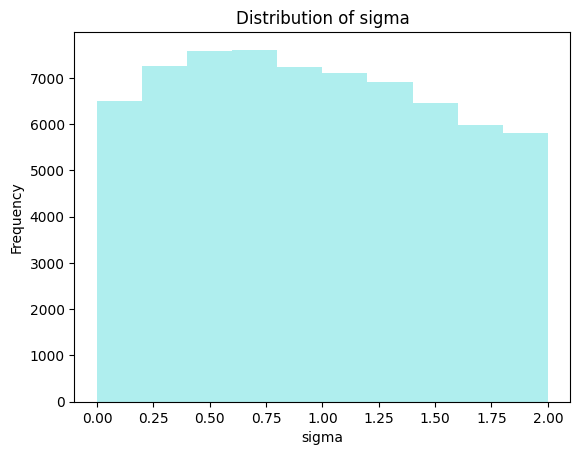

In [ ]:
# Plot distribution of sigma
plt.hist(sim_data_cleaned['sigma'], color = 'paleturquoise')
plt.xlabel('sigma')
plt.ylabel('Frequency')
plt.title('Distribution of sigma')
plt.show()

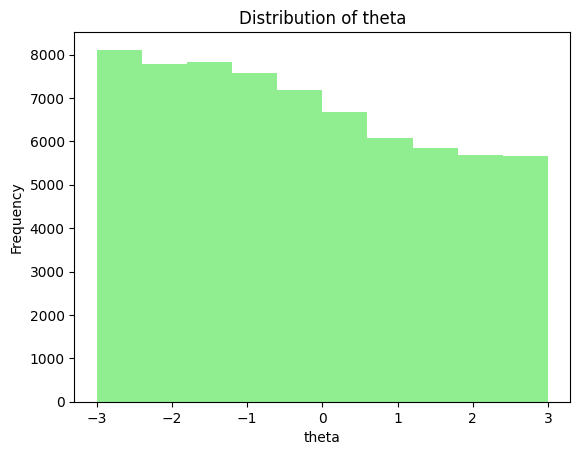

In [ ]:
# Plot distribution of theta
plt.hist(sim_data_cleaned['theta'], color = 'lightgreen')
plt.xlabel('theta')
plt.ylabel('Frequency')
plt.title('Distribution of theta')
plt.show()

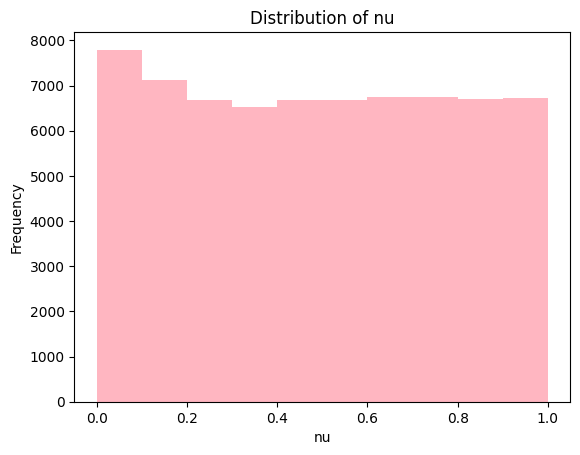

In [ ]:
# Plot distribution of nu
plt.hist(sim_data_cleaned['nu'], color = 'lightpink')
plt.xlabel('nu')
plt.ylabel('Frequency')
plt.title('Distribution of nu')
plt.show()

In [ ]:
# Get amount of cleaned out rows and display nicely
cleaned_rows = len(sim_data) - len(sim_data_cleaned)
print(f"The amount of rows which have been filtered are: {cleaned_rows}")

# Also display amount of rows in cleaned dataset
print(f"The amount of rows in cleaned dataset: {len(sim_data_cleaned)}")

The amount of rows which have been filtered are: 31577
The amount of rows in cleaned dataset: 68423


There are still `68423` rows left, this is a way to large a set to train a GPR model on (due to the computational expensive Kernel Matrix calculation), hence a subset will be selected of this to train the models on.

In [ ]:
# Get subset of cleaned dataset
sim_data_subset = sim_data_cleaned.sample(n=60000, random_state=7)

### Model training (KNN, NN, GPR)

In order to train the models, first the features variables (X) and target variable (y) needs to be defined. After defining this, a train/test split of 60/40, respectively, is done.


In [ ]:
# Build feature matrix X and target vector y from simulation data.
# Features: [theta, sigma, nu, strike]; Target: call price.
X = sim_data_subset[['theta', 'sigma', 'nu', 'strike']].values
y = sim_data_subset['call_price'].values

# Split simulation data into training and testing sets (60/40 split).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=7)

#### KNN

The KNN model will now be initiated on the simulated dataset, by which the amount of neighbours is selected by cross-validation on the training set. With this optimal amount of neighbors, the test set prediction will be evaluated on `Mean Squared Error`.

`cross validation` can only be used when using the `KNeighborsRegressor` package, hence for the optimal neighbors selection this method will be used, however the custom KNN model will be used with this optimal `k`-value.


Optimal k: 5


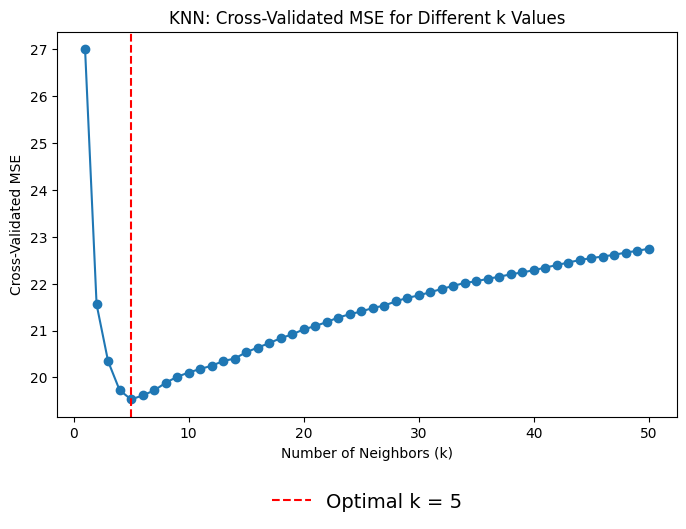

In [ ]:
# Define a range of k values to try
k_values = list(range(1, 51))
cv_mse = []

# Loop over k values
for k in k_values:

    # Get knn with k amount of neighbours selected
    knn = KNeighborsRegressor(n_neighbors=k)

    # Use 5-fold cross-validation; scoring returns negative MSE so we take the negative.
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

    # Append to cv_mse list
    cv_mse.append(-np.mean(scores))

# Find the optimal k (lowest MSE)
optimal_k = k_values[np.argmin(cv_mse)]
print("Optimal k:", optimal_k)

# Plot MSE vs k
plt.figure(figsize=(8, 5))
plt.plot(k_values, cv_mse, marker='o', linestyle='-')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Cross-Validated MSE")
plt.title("KNN: Cross-Validated MSE for Different k Values")
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=1, frameon=False, fontsize=14)
plt.show()

Now the knn model can be run with this optimal amount of neighbours.

In [ ]:
# Get prediction of the KNN model
y_pred_knn = knn_predict(X_train, y_train, X_test, k=optimal_k)

# Get MSE of test set and display nicely
mse_knn = np.mean((y_pred_knn - y_test)**2)
print("KNN MSE:", mse_knn)

KNN MSE: 17.379597780268824


#### GPR

The GPR model doesn't need a hyperparameter selection, hence it can just be ran on the subset of the dataset, however due to computational times it will be implemented via batches and vectorisation to speed up the model.

In [ ]:
# Define the batch size
batch_size = 64

# Get predictions of the GPR model, we take the mean-value
y_pred_batch_gpr = vectorized_parallel_gpr_predict(X_train, y_train, X_test, batch_size, theta_1=1, theta_2=1, n_jobs=-1)

# Get MSE of test set and display nicely
mse_batch_gpr = np.mean((y_pred_batch_gpr - y_test)**2)
print(f"Batch GPR MSE (batch_size={batch_size}):", mse_batch_gpr)

12
Computing training kernel matrix...
Computing kernel matrix inverse...
Processing 375 batches in parallel...
Batch GPR MSE (batch_size=64): 60.45256033655519


#### NN

The same accounts for the Neural Network

In [ ]:
# Define and fit the Neural Network model
nn_model = create_nn_model(input_dim=X_train.shape[1])
nn_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2, validation_split=0.2)

# Get predictions of the NN model
y_pred_nn = nn_model.predict(X_test).flatten()

# Get MSE of test set and display nicely
mse_nn = np.mean((y_test - y_pred_nn) ** 2)
print(f"Keras Neural Network MSE: {mse_nn:.4f}")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


900/900 - 4s - 5ms/step - loss: 1983.7894 - val_loss: 600.5201
Epoch 2/100
900/900 - 2s - 2ms/step - loss: 322.8148 - val_loss: 153.3893
Epoch 3/100
900/900 - 2s - 2ms/step - loss: 105.9434 - val_loss: 72.4267
Epoch 4/100
900/900 - 2s - 2ms/step - loss: 69.2188 - val_loss: 53.6330
Epoch 5/100
900/900 - 2s - 2ms/step - loss: 54.9982 - val_loss: 46.3455
Epoch 6/100
900/900 - 2s - 2ms/step - loss: 47.7195 - val_loss: 30.6749
Epoch 7/100
900/900 - 2s - 2ms/step - loss: 40.5893 - val_loss: 55.3642
Epoch 8/100
900/900 - 2s - 2ms/step - loss: 38.1587 - val_loss: 64.3978
Epoch 9/100
900/900 - 2s - 2ms/step - loss: 34.0740 - val_loss: 30.5238
Epoch 10/100
900/900 - 2s - 2ms/step - loss: 33.3077 - val_loss: 37.1955
Epoch 11/100
900/900 - 2s - 2ms/step - loss: 31.5068 - val_loss: 26.5693
Epoch 12/100
900/900 - 2s - 2ms/step - loss: 35.0109 - val_loss: 27.6830
Epoch 13/100
900/900 - 2s - 2ms/step - loss: 32.8916 - val_loss: 26.5552
Epoch 14/100
900/900 - 2s - 2ms/step - loss: 30.6372 - val_loss: 6

The model diagnostics (on the test set it's MSE) can now be compared to determine the most optimal model based on the simulated dataset

In [ ]:
print("Model Diagnostics (Test MSE):")
print(f"Custom KNN MSE: {mse_knn:.4f}")
print(f"Custom Gaussian Process MSE: {mse_batch_gpr:.4f}")
print(f"Keras Neural Network MSE: {mse_nn:.4f}")

Model Diagnostics (Test MSE):
Custom KNN MSE: 17.3796
Custom Gaussian Process MSE: 60.4526
Keras Neural Network MSE: 8.4630


We can also automatically determine this best model, with no human intervention!

In [ ]:
# Determine best model (lowest MSE)

# Obtain a list of all MSE's, models and names
mse_list = [mse_knn, mse_batch_gpr, mse_nn]
models = [knn_predict,  vectorized_parallel_gpr_predict, nn_model]
model_names = ["Scikit KNN", "Custom Gaussian Process",  "Keras Neural Network"]

# Determine best model (lowest MSE) and display it
best_index = np.argmin(mse_list)
best_model = models[best_index]
best_model_name = model_names[best_index]
print(f"Best model selected: {best_model_name}")

Best model selected: Keras Neural Network


### Model Parameter Calibration

Since the most optimal model has been selected, the model will now be implemented for the most optimal model parameters of the VG-Model, in order to obtain the most optimal prediction model. The model selection was solely based on one single `strike`, `maturity`, `interest_rate` and `stock_price`, whereas now it is for different ones without the parameter values (which we need to optimally choose by the model).

First the market dataset is loaded.

In [ ]:
market_data = load_market_data('/content/drive/MyDrive/MLF Assignment/DJIA_options(original_data).xlsx')

In [ ]:
market_data.head()

,maturity,strike,call
0,30,180,61.800
1,30,185,56.800
2,30,186,55.800
3,30,187,54.825
4,30,188,53.850


Secondly the Calibration Objective, which basically is the objective function which calculates the MSE given the `parameter` values, the `market strikes`, `market prices` and the chosen `model`, eventually the calibration will only be capable of altering the `parameter` values (hence the minimization). This will be done via a forloop, in which the score gets saved each time and the most optimal MSE is kept.


In [ ]:
# ---------------------------
# Calibration: Objective
# ---------------------------
def calibration_objective(theta, sigma, nu, market_strikes, market_prices, model):
    """
    For given VG parameters [theta, sigma, nu], build features for each market strike,
    predict call prices using the model, and compute the mean squared error vs. market data.
    """

    # Build feature matrix: each row is [theta, sigma, nu, strike]
    X_calib = np.column_stack([
        np.full_like(market_strikes, theta),
        np.full_like(market_strikes, sigma),
        np.full_like(market_strikes, nu),
        market_strikes
    ])

    # Get predictions of y
    y_pred = model.predict(X_calib)

    # Since using a Keras model, flatten the output
    y_pred = y_pred.flatten()

    # Compute mse and return
    mse = np.mean((y_pred - market_prices) ** 2)
    return mse

Next the Calibration Model is initiated, in which different `parameter` values are tried on the Objective function over the possible feature grid. Based on the `Objective` function, the optimal `parameters` are selected and returned. Also a plot of the `call_prices` on different strikes with the optimally found `parameters` is displayed, showing how the optimal ML model performs compared to the true `call_prices` of the test set.

In [ ]:
def calibrate_model(model, market_data):
    """
    Calibrate the best ML model to the market data by optimizing the VG parameters.
    Implementing a forloop through a grid for this.
    """
    # Get market strikes and prices
    market_strikes = market_data['strike'].values
    market_prices = market_data['call'].values

    # Define the grids
    theta_grid = np.linspace(-3, 3, 15)
    sigma_grid = np.linspace(0, 2, 15)
    nu_grid = np.linspace(0, 1, 15)

    # Loop through the grids and try different values
    mse_expr_list = [10000000]
    theta_cal = 1
    sigma_cal = 1
    nu_cal = 1
    for theta in theta_grid:
        for sigma in sigma_grid:
            for nu in nu_grid:
                mse_expr = calibration_objective(theta, sigma, nu, market_strikes, market_prices, model)
                if mse_expr < np.min(mse_expr_list):
                    mse_expr_list.append(mse_expr)
                    theta_cal = theta
                    sigma_cal = sigma
                    nu_cal = nu

    # Visualize market prices vs. model predictions using the calibrated parameters
    X_calib = np.column_stack([
        np.full_like(market_strikes, theta_cal),
        np.full_like(market_strikes, sigma_cal),
        np.full_like(market_strikes, nu_cal),
        market_strikes
    ])
    market_predictions = model.predict(X_calib)
    if isinstance(market_predictions, np.ndarray) and market_predictions.ndim > 1:
        market_predictions = market_predictions.flatten()

    plt.figure(figsize=(8, 5))
    plt.plot(market_strikes, market_prices, 'o', label='Market Prices')
    plt.plot(market_strikes, market_predictions, '-', label='Model Predictions')
    plt.xlabel('Strike')
    plt.ylabel('Call Price')
    plt.title('Calibration: Market vs. Model Call Prices')
    plt.legend()
    plt.show()

    return theta_cal, sigma_cal, nu_cal, mse_expr_list

Now the method will be ran and the optimal parameter values will be computed and displayed

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━

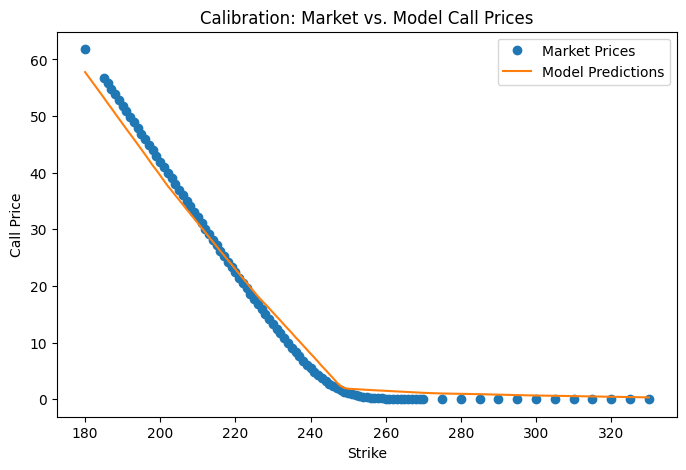

In [ ]:
calibrated_params = calibrate_model(best_model, market_data)

In [ ]:
# Obtain the optimal values for the model parameters and the list of MSE values
theta, sigma, nu, list = calibrated_params
print(f"The optimal theta value is {theta}")
print(f"The optimal theta value is {sigma}")
print(f"The optimal theta value is {nu}")

The optimal theta value is -1.7142857142857144
The optimal theta value is 0.0
The optimal theta value is 0.0


In [ ]:
# Print the list of MSE values (descending=TRUE)
print(list)

[10000000, 79.59800147840542, 25.756206342400596, 3.5171324211475645]
